# Classifying CIFAR10 images using ResNets, Regularization and Data Augmentation in PyTorch.

importing libraries

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
# Data transforms (normalization and data augmentation)
stats = ((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
train_trms = tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                        #  tt.RandomRotation(10),
                        #  tt.RandomResizedCrop(256,scale=(0.5,0.9),ratio=(1,1)),
                        #  tt.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])

valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

Downloading training and testing dataset of CIFAR10

In [3]:
train_dataset = CIFAR10(root='data/CIFAR10/train/',train=True, transform=train_trms, download=True)
valid_dataset = CIFAR10(root='data/CIFAR10/test/',train=False, transform=valid_tfms, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(train_dataset),len(valid_dataset)

(50000, 10000)

Listing down all the classes

In [5]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. $\textbf{Use test set for validation}$ : instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as out validation set. This just gives a little more data to train with. In genereal, once you have picked the best model architecture and hyperparameters using a fixed validation set, it is a good idea to retain the same model on the entire dataset just to give it a small final boost in performance.

2. $\textbf{Channel-wise data normalization}$ : We will normalize the image tenosr by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that offer.

3. $\textbf{Randomized data augmentaions}$ : We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels,and then take a random crop of size 32 x 32 pixels. and then flip the image horizantally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better

In [6]:
# PyTorch data loaders
train_dl = DataLoader(train_dataset, batch_size=256,shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size=512, num_workers=4, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to denormalize the pixels values to bring them back into the range `(0,1)`

In [7]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)

    return images * stds + means

def show_batch(dl):
    for images, _ in dl:
        _,ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64],nrow=8).permute(1,2,0).clamp(0,1))
        break

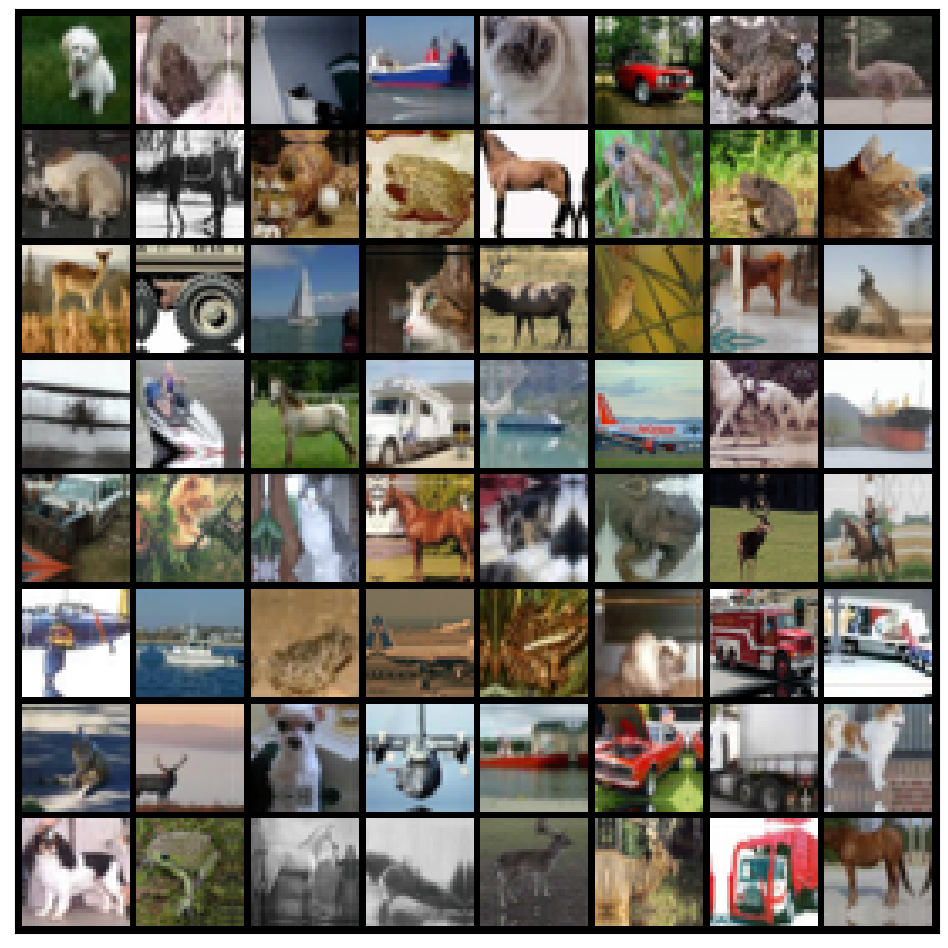

In [8]:
show_batch(train_dl)

## Using a GPU

To seamlessly use a GPU, if one is availaible, we define a couple of helper functions, and a helper class to move our model and data to the GPU as required.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
def to_device(data, device):
    if isinstance(data,(tuple,list)):
        return [to_device(x,device) for x in data]
    
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dl , device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to GPU (if availaible)

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

One of the keychanges to out CNN model this time is the addition of the residual block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

In [12]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1,padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)

        return self.relu2(out) + x

In [13]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([256, 3, 32, 32])


In [14]:
def accuracy(outputs,labels):
    _, preds = torch.max(outputs, dim=1)

    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images,labels = batch
        out = self(images)                  # generate predictions
        loss = F.cross_entropy(out,labels)  # calculate loss

        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # calculate loss
        acc = accuracy(out,labels)          # Calculate accuracies

        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = []
        batch_accs = []
        for x in outputs:
            batch_losses.append(x['val_loss'])
            batch_accs.append(x['val_acc'])

        epoch_loss = torch.stack(batch_losses).mean() # combining losses
        epoch_acc = torch.stack(batch_accs).mean()    # Combining accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self,epoch,result):
        print(f"Epoch [{epoch+1}], train_loss : {result['val_loss']}, val_acc : {result['val_acc']}")


In [15]:
def conv_block(in_channels, out_channels, pool = False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if pool : layers.append(nn.MaxPool2d(2))

    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64,128,True)
        self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128))

        self.conv3 = conv_block(128,256, True)
        self.conv4 = conv_block(256,512, True)
        self.res2 = nn.Sequential(conv_block(512,512),conv_block(512,512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512,num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)

        return out 

In [16]:
model = to_device(ResNet9(3,10),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

1. $\textbf{Learning rate scheduling }$: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many startegies for varying the learning rate during training, and the one we'll use is called the "$\textbf{One Cycle Learning Rate Policy}$, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

2. $\textbf{Weight decay}$ : We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

3. $\textbf{Gradient clipping}$ : Apart from the layer weights and outputs, it is also helpful to limit the values of gradients to small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.

Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]

    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay = 0, grad_clip = None, opt_func = torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # setup custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr,weight_decay=weight_decay)

    # setup one-cycle learining rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record and update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        #validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [18]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.303022861480713, 'val_acc': 0.10877756774425507}]

We're now ready to train out model. Instead of SGD( stochastic gradient descent). We'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training.

In [19]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [20]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [1], train_loss : 2.3656468391418457, val_acc : 0.4373161792755127
Epoch [2], train_loss : 1.2494131326675415, val_acc : 0.615590512752533
Epoch [3], train_loss : 0.9805893898010254, val_acc : 0.6929055452346802
Epoch [4], train_loss : 0.7648828625679016, val_acc : 0.7488683462142944
Epoch [5], train_loss : 0.5197134017944336, val_acc : 0.822053074836731
Epoch [6], train_loss : 0.39603257179260254, val_acc : 0.8661362528800964
Epoch [7], train_loss : 0.2979573607444763, val_acc : 0.8991613388061523
Epoch [8], train_loss : 0.27838706970214844, val_acc : 0.9075137972831726


Let's plot the validation set accuracies to study how the model improves over time

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel("epoch")
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

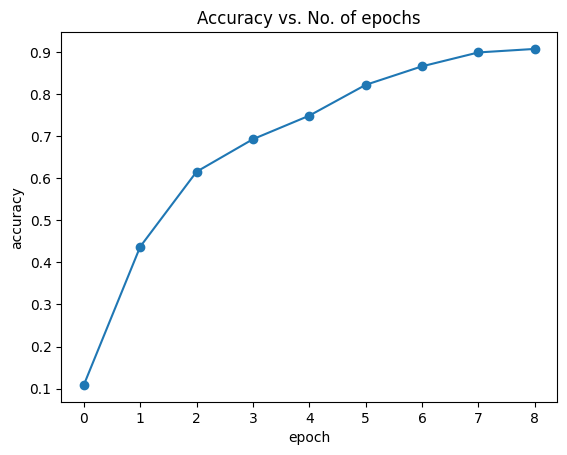

In [22]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend

In [23]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-ro')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs. No. Of epochs');

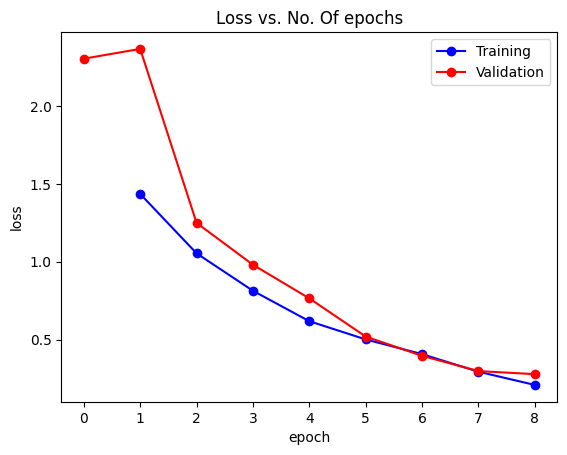

In [24]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [26]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs',[]) for x in history])
    plt.plot(lrs)
    plt.xlabel("Batch no.")
    plt.ylabel("Learning rate")
    plt.title("Learning rate vs. Batch no.")

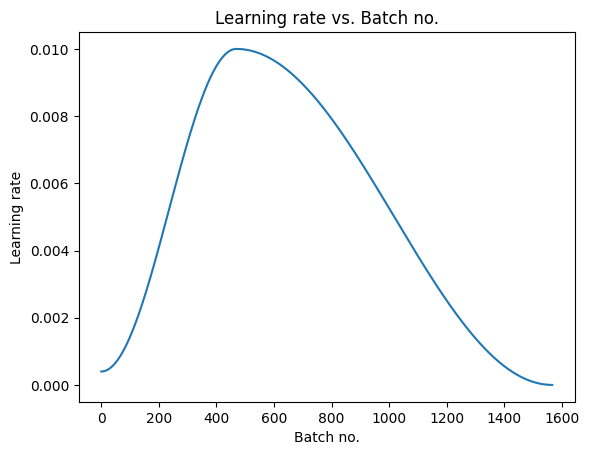

In [27]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decrease to a very small value.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images, Let's test out our model with some images from the predefined test dataset of 10000 images.

In [28]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _,preds = torch.max(yb, dim = 1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

Label : cat, Predicted : cat


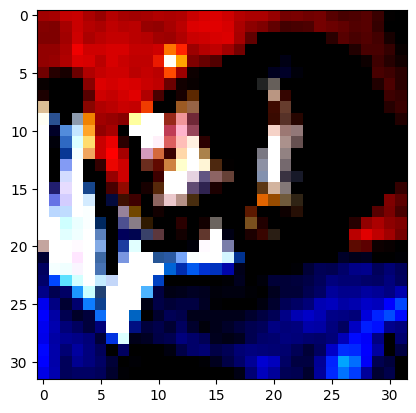

In [29]:
img, label = valid_dataset[0]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print(f'Label : {train_dataset.classes[label]}, Predicted : {predict_image(img, model)}')

Label : ship, Predicted : ship


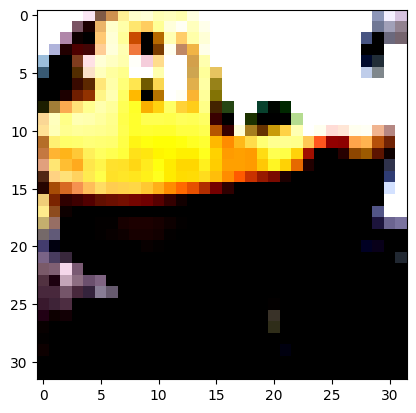

In [30]:
img, label = valid_dataset[1002]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print(f'Label : {train_dataset.classes[label]}, Predicted : {predict_image(img, model)}')

Label : truck, Predicted : truck


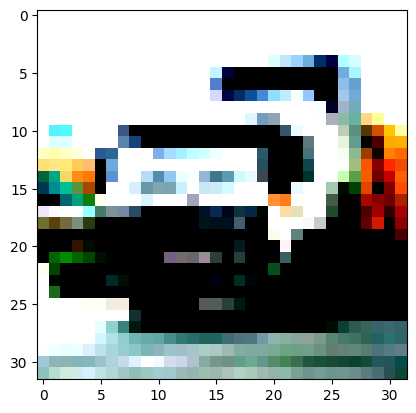

In [31]:
img, label = valid_dataset[1653]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print(f'Label : {train_dataset.classes[label]}, Predicted : {predict_image(img, model)}')

## Saving the model

Let's save the weights of the model, record the hyperparameters.

In [32]:
torch.save(model.state_dict(), 'models/cifar10-resnet9.pth')

## Summary

1. $\textbf{Data normalization}$ : We normalized the image tensor by subtracting the mean and dividing by the standard deviation of pixel across each channel. Normalizing the data prevents the pixel values from any one channel from disproporitionately affecting the losses and gradients.

2. $\textbf{Data augmentation}$ : We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixel, and then take a random crop of size 32x32 pixels, and then flip the image horizantally with a 50% probability.

3. $\textbf{Residual connections}$ : One of the key changes to our CNN model was the addition of the residual block, which adds the original inpur back to the output feature map obtained by passing the input through one or more convolution layers. We used ResNet9 architecture.

4. $\textbf{Batch normalization}$ : After each convolution layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the output of a layer, and the mean and standard deviation are learned parameters.

5. $\textbf{Learning rate scheduling}$ : Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many startegies for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy"

6. $\textbf{Weight decay}$ : We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

7. $\textbf{Gradient clipping}$ : We also added gradient clippint, which helps limit the value of gradient to a small range to prevent undesirable changes in model parameters due to large gradient values doing training.

8. $\textbf{Adam optimizer}$ : Instead of SGD (stochastic gradient descent), we use the Adam Optimizer which uses techniques like momentum and adaptive learning rates for faster training. There are many other optimizers to choose.